# Steps
## step 1: data loading

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Obtain target and predictors
y = X_full.SalePrice

features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()
# OR X.drop(['SalePrice'], axis=1, inplace=True)

# data preprocessing (if needed)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, 
                                                      random_state=0)

# data preview
X_train.head()         # print the first several rows of the data.
X_train.describe()     # index of list showing the columns 


## step 2: evaluate several models

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [ ]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)                         # fit model
    preds = model.predict(X_v)                  # predict
    return mean_absolute_error(y_v, preds)      # selection criteria - MAE

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

## step 3: generate test prediction

In [ ]:
my_model = model_3 # Your code here
my_model.fit = (X, y)
preds_test = my_model.predict(X_test)
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

# common algorithms
## Decision-tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state = 1)

### Overfitting and Underfitting
* overfitting: tree too deep -> match training data perfectly but do poorly on validation and other new data
    * capturing spurious patterns that won't recur in the future, leading to less accurate predictions,
* underfitting: tree not deep enough -> perform bad even for training data
    * failing to capture relevant patterns, again leading to less accurate predictions.
* solution
    * adjust the max_leaf_nodes argument

In [ ]:
def get_mae(max_leaf_nodes, train_X, val_X, train_Y, var_Y}:
            model = DeciosionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state = 0)
            model.fit(train_X, train_y)
            predicts = model.predict(val_X)
            mae = mean_absolute_error(val_Y, predicts)
            return(mae)
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key = scores.get)

## Random froest regressor
* Basic idea: 
    * The random forest uses many trees, and it makes a prediction by averaging the predictions of each component tree. 
    * It generally has much better predictive accuracy than a single decision tree
    * it works well with default parameters. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state = 1)
forest_model.fit(train_X, train_y)

* parameters
    * n_estimators # number of trees
    * criterion
    * max_depth, min_samples_split, min_samples_leaf, ....
    * random_state


## Gradient boosting
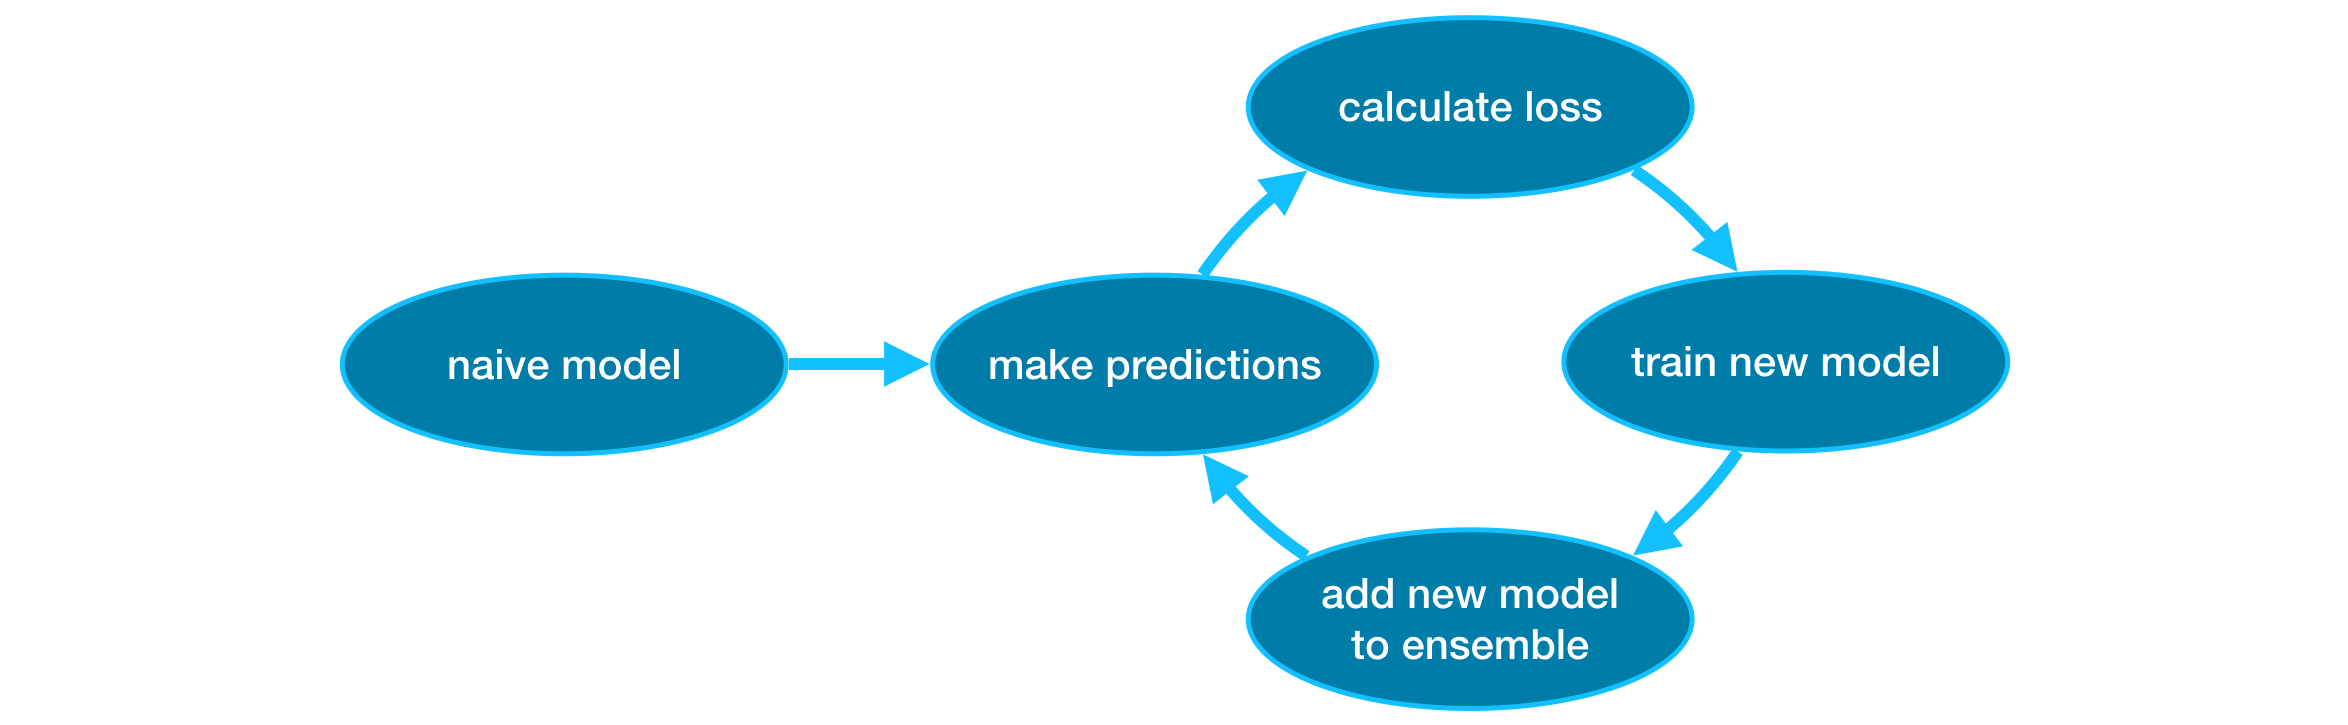

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

* parameters
    * in SGBRegressor
        * n_estimators: specifies how many times to go through the modeling cycle = no. of modles in the ensemble. typical value 100 - 1000, though depends a lot on learning_rate
        * learning_rate: multiply each prediction by smaller learning_rate before adding them in -> each tree helps us less, so we can set higher n_estimators without overfitting
        * n_jobs: on large data set, use parallelism to help it work faster - does not affect model, but save time to run
    * in my_model.fit
        * early_stopping_rounds: offers a way to automatically find the ideal value for n_estimators, 5 is a resonable choice
            * my_model.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = [(x_valid, y_valid)], verbose = False)


# data preprocessing
## missing values
* preliminary investigation

In [ ]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())    #.isnull return array-like of bool or bool; 
print(missing_val_count_by_column[missing_val_count_by_column > 0])

* simple approach: Drop Columns with Missing Values
    * lead to loss of valuable data if relatively few in each column is missing
* Imputation: fills in the missing values with some number (e.g. mean)
* improved imputation
    * add a new column that shows the location of the imputed entries

In [ ]:
# approach 1
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

In [ ]:
# approach 2
from sklearn.impute import SimpleImputer
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [ ]:
# approach 3 

# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

## categoriacal variables

## Pipelines
* Step 1: Define Preprocessing Steps
* Step 2: Define the Model
* Step 3: Create and evaluate pipelines

In [ ]:
# after splitting into training and valid

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),     #for categorical data, only 'most_frequent' or 'constant' can be used
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Define a model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)


from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [ ]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# Cross-validation
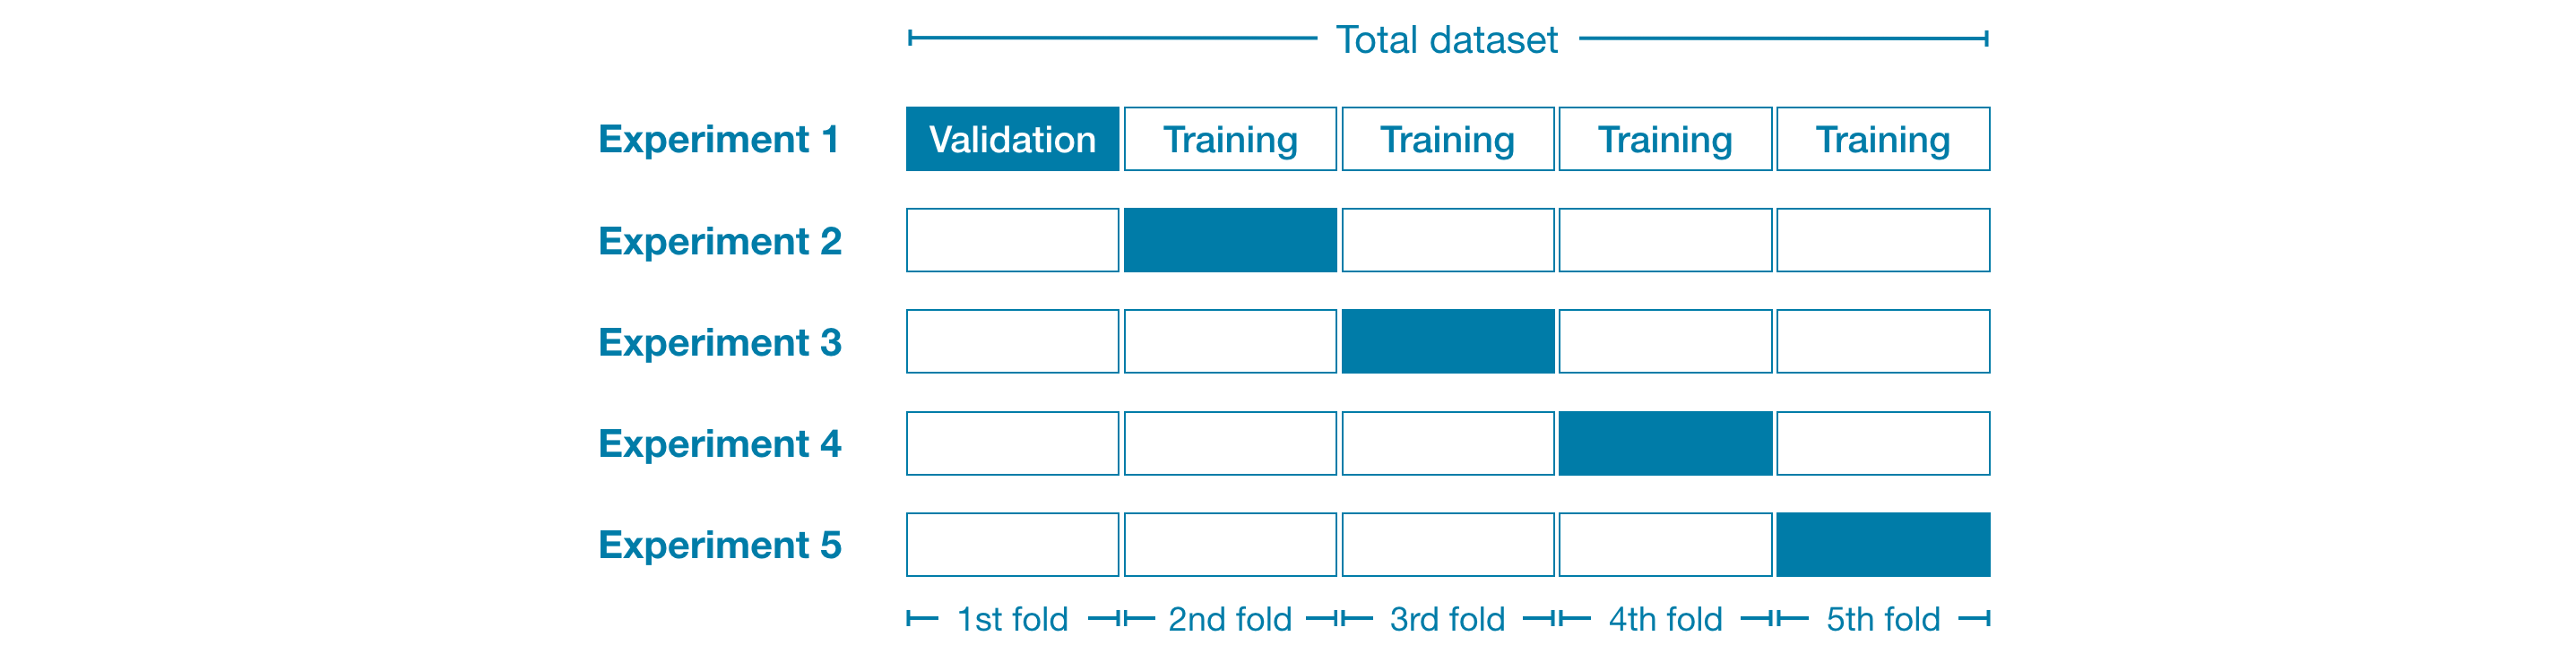
* gives a more accurate measure of model quality, but takes longer to run
    * For small datasets, where extra computational burden isn't a big deal, you should run cross-validation. (takes fewer than minutes to run)
    * For larger datasets, a single validation set is sufficient. 
    * Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

In [ ]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
print("MAE scores:\n", scores)

print("Average MAE score (across experiments):")
print(scores.mean())

In [ ]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')   #alternative scoring 'accuracy'
    return scores.mean

results = {}
for i in range(1, 9):
    results[50*i] = get_score(50*i)

# plot different MAE with different n_estimator
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results.keys(), results.values())
plt.show

# Data leakage
* get good validation scores, but perform poorly on real predictions
* target leakage
    * Occurs when your predictors include data that will not be available at the time you make predictions. 
    * important to consider the timing or chronological order 
    * To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded. make sure all features should be available at the moment you want to make a predition
* train-test contamination
    * e.g. run preprocessing before calling train_test_split() -> incorporate data from valid data into how you make predictions